Задача состоит в необходимости предсказать риск проблем с сердцем (колонка output) на основе данных с kaggle.
Будем рассматривать несколько алгоритмов классификатором, сравнивать полученный результат по метрикам качества на тесте.

Далее действуем в следующей последовательности:

1. Загружаем небходимые библиотеки и данные 
2. Первичное исследование(аномалии, проспуски, корректность)
3. Основное исследование - разведывательный анализ (EDA - баланс классов, линейные корреляции, группировки и графики с target`ом)
4. Предобработка (стратификация, скалеры)
5. Построение алгоритмa KNN и перебор гиперпараметров -> Оценка -> Выбор
6. Построение других алгоритмов
6. Оценка алгоритмов


### 1. Загрузка библиотек и данных 

In [650]:
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from my_utils import clr
from my_utils import grid_knn
from my_utils import grid_plot

In [651]:
df = pd.read_csv('https://raw.githubusercontent.com/hosiajosindra/heart-attack-classification/main/heart.csv')   # подгружаем в пандас
df.head()
print(' ВСЕ ДАННЫЕ И БИБЛИОТЕКИ ЗАГРУЖЕНЫ ')
print(f'У нас - \nСтрок: {df.shape[0]} \nКолонок: {df.shape[1]}') 

 ВСЕ ДАННЫЕ И БИБЛИОТЕКИ ЗАГРУЖЕНЫ 
У нас - 
Строк: 303 
Колонок: 14


#### ЛЕГЕНДА

age - возраст пациента   
sex - пол пациента   
cp - тип боли в груди:   
*   0 = типичная стенокардия
*   1 = атипичная стенокардия
*   2 = боль не как при стенокардии   
*   3 = без симптомнов     

trtbps - артериальное давление покоя (в мм ртутного столба)   
chol - холестерин   
fbs - уровень сахара в крови    
 *   1 = больше > 120    
 *   0 = меньше < 120    
 
restecg - результаты ЭКГ   
 *   0 = Норма,    
 *   1 = ST-T Норма,    
 *   2 = гипертрофия левого желудочка   

thalachh - Максимальное сердцебиение(частота сердечных сокращение)   
oldpeak - предыдущий пик   
slp - наклон   
caa - количество крупных сосудов   
thall - результат стресс теста ~ (0,3)   
exng - стенокардия вызванная физической нагрузкой   
 *   1 = Yes,    
 *   0 = No   
 
output - целевая переменная   

### 2. Первичное исследование

Посмотрим на типы данных в таблице и на память используюмую для хранения.   
    
    
Видим, что для данных используется достоточно объемные типы данных, а имеено 'int64', 'float64', числа далеки от указанных типов уменьшим пасмять используюмую для хранения сменив тип данных на более подходящий.

In [652]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [653]:
# изменяем на int16 и float 32
col_to_int16 = np.delete(np.array(df.columns), [9])
col_to_int16
df[col_to_int16] = df[col_to_int16].astype('int16')
df['oldpeak'] = df['oldpeak'].astype('float32')
df.info()
# Размер используемой памяти уменшится в 3.7 раз

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int16  
 1   sex       303 non-null    int16  
 2   cp        303 non-null    int16  
 3   trtbps    303 non-null    int16  
 4   chol      303 non-null    int16  
 5   fbs       303 non-null    int16  
 6   restecg   303 non-null    int16  
 7   thalachh  303 non-null    int16  
 8   exng      303 non-null    int16  
 9   oldpeak   303 non-null    float32
 10  slp       303 non-null    int16  
 11  caa       303 non-null    int16  
 12  thall     303 non-null    int16  
 13  output    303 non-null    int16  
dtypes: float32(1), int16(13)
memory usage: 9.0 KB


In [654]:
df[df.duplicated()]  # проверяем на дупликаты - есть один дубликат 

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [655]:
# Уберем дубликат и посмотрим на размерность еще раз
df.drop_duplicates(keep='first',inplace=True)
print(f'Строк: {df.shape[0]} \nКолонок: {df.shape[1]}') 

Строк: 302 
Колонок: 14


In [656]:
df.isnull().sum()   # Пропусков нет

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [657]:
df.describe().T  # посмотрим на основные статистики

,count,mean,std,min,25%,50%,75%,max
age,302.0,54.420530,9.047970,29.0,48.00,55.5,61.00,77.0
sex,302.0,0.682119,0.466426,0.0,0.00,1.0,1.00,1.0
cp,302.0,0.963576,1.032044,0.0,0.00,1.0,2.00,3.0
trtbps,302.0,131.602649,17.563394,94.0,120.00,130.0,140.00,200.0
chol,302.0,246.500000,51.753489,126.0,211.00,240.5,274.75,564.0
fbs,302.0,0.149007,0.356686,0.0,0.00,0.0,0.00,1.0
restecg,302.0,0.526490,0.526027,0.0,0.00,1.0,1.00,2.0
thalachh,302.0,149.569536,22.903527,71.0,133.25,152.5,166.00,202.0
exng,302.0,0.327815,0.470196,0.0,0.00,0.0,1.00,1.0
oldpeak,302.0,1.043046,1.161453,0.0,0.00,0.8,1.60,6.2


### № 3. EDA

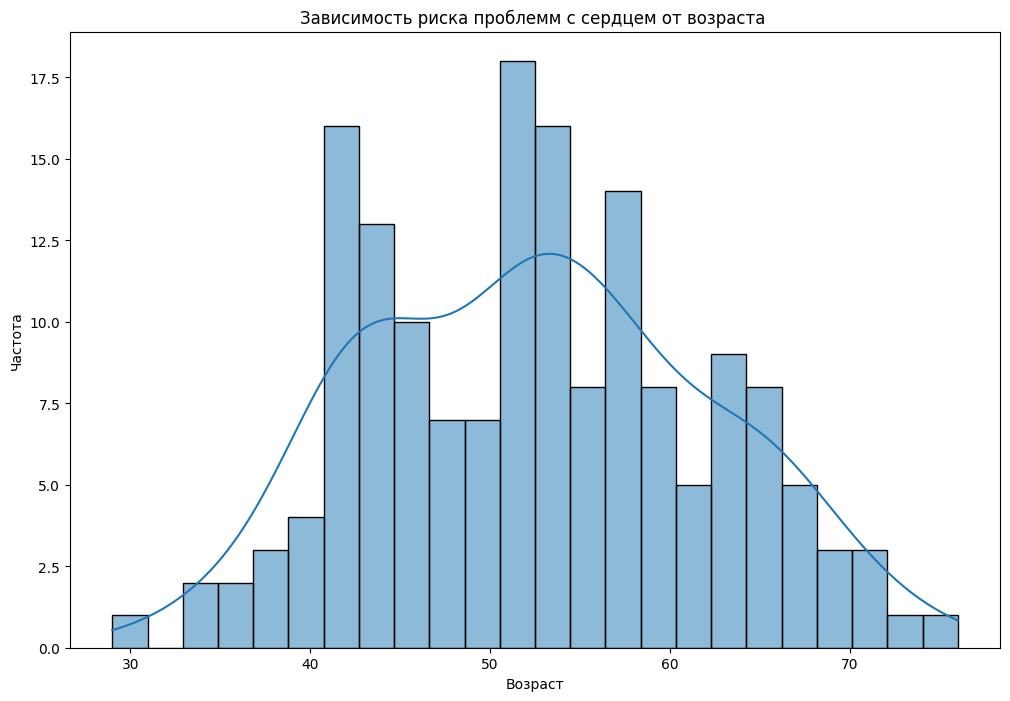

In [658]:
fig = plt.figure(figsize=(12,8))
dat = df['age']*df['output']
dat= dat[dat != 0]
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title("Зависимость риска проблемм с сердцем от возраста ")
sns.histplot(data=dat,binwidth=2,kde=True);

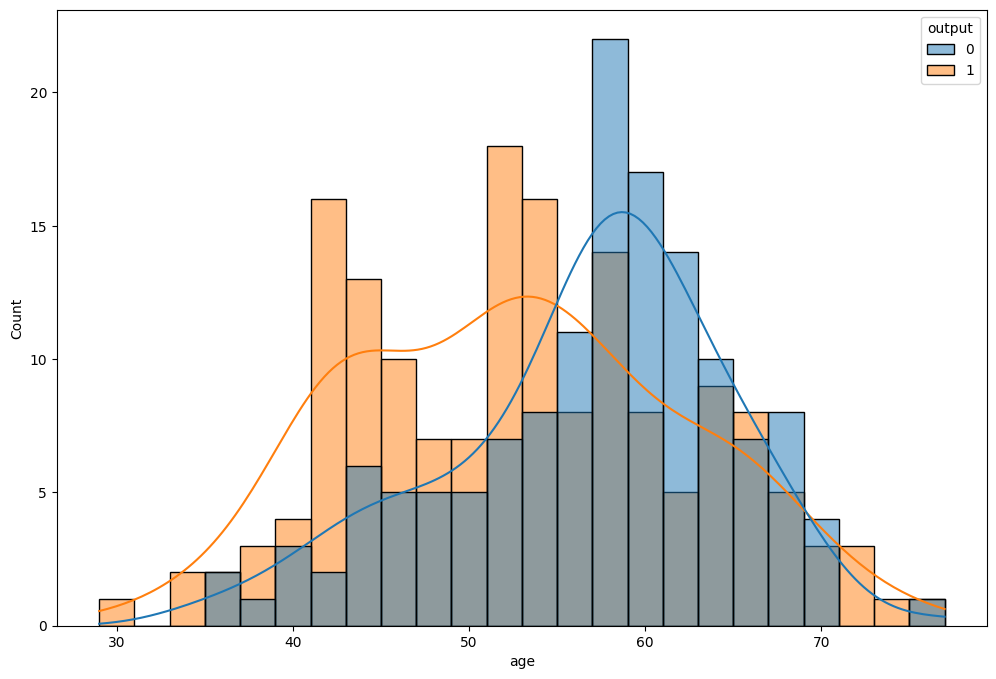

In [659]:
fig = plt.figure(figsize=(12,8))
sns.histplot(data=df, x="age", binwidth=2, hue="output",kde=True);

Здесь видно, что у людей в возрасте от 40-60 лет риск сердечного приступа больше чем у остальных.

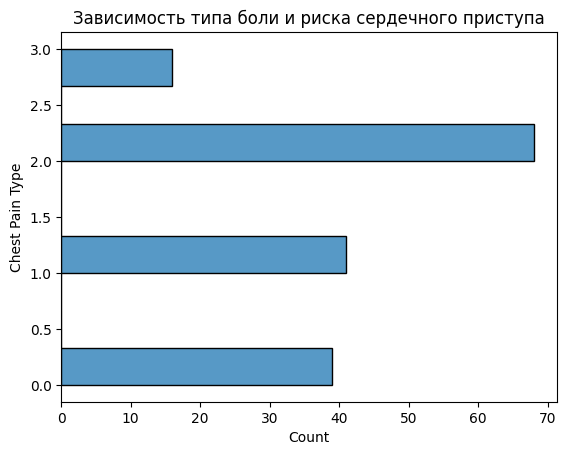

In [660]:
dat = df['cp']
dat = dat[df['output'] !=0]
plt.title("Зависимость типа боли и риска сердечного приступа")
plt.ylabel("Chest Pain Type")
sns.histplot(y=dat);

Из графика видно, 
что люди с болями 2 типа больше всего подвержены риску сердечного приступа.

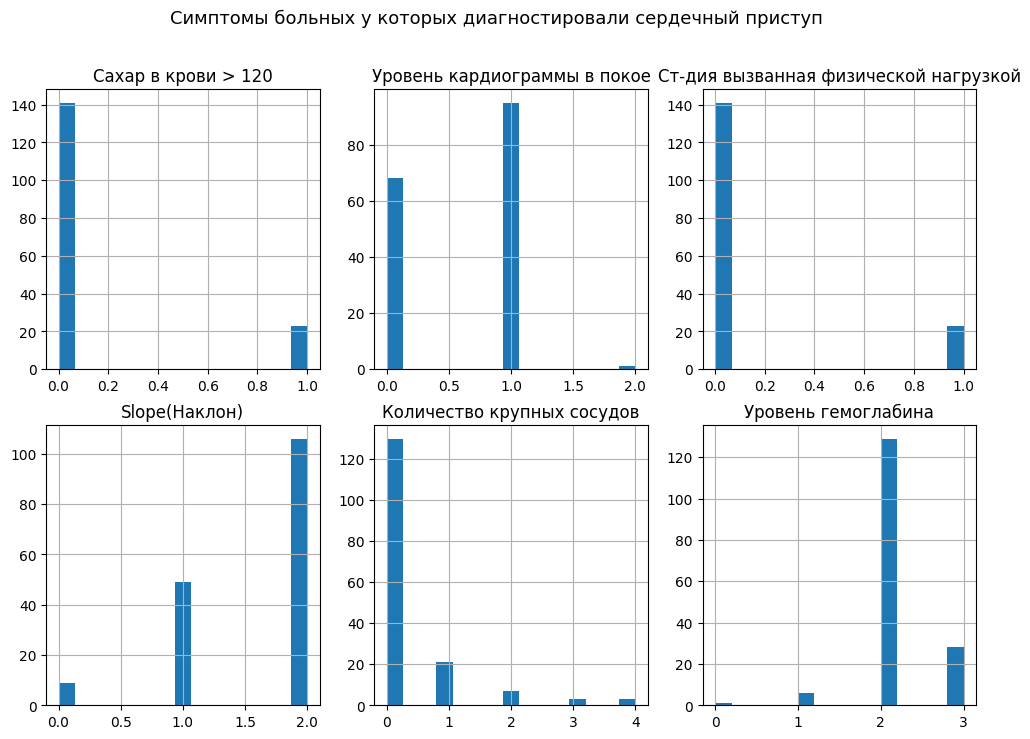

In [661]:
column_t = ['fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
title_t = [
            "Сахар в крови > 120", "Уровень кардиограммы в покое", 
            "Ст-дия вызванная физической нагрузкой", "Slope(Наклон)",
            "Количество крупных сосудов", "Уровень гемоглабина"
]
mask = df['output'].apply(lambda x: x != False)

plt.figure(figsize=(12,8))
plt.suptitle("Симптомы больных у которых диагностировали сердечный приступ", fontsize=13)

for i in range(len(column_t)):
    plt.subplot(2, 3, i+1)
    dat = df[column_t[i]][mask]
    plt.title(title_t[i])
    dat.hist(bins =15)


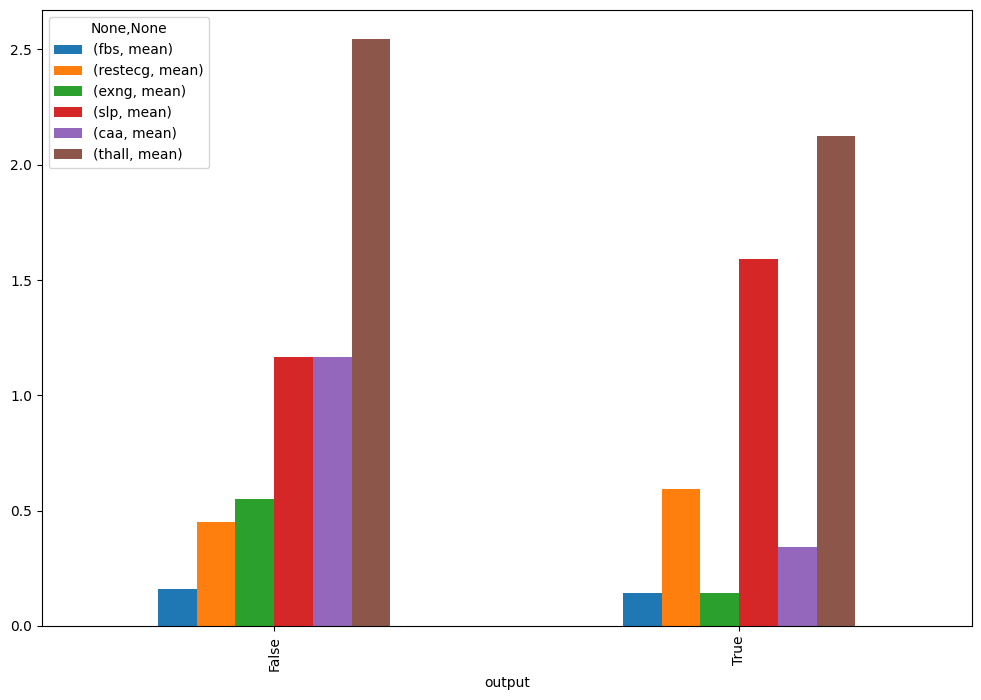

In [662]:
df.groupby(mask)[column_t].agg([np.mean]).plot(kind='bar', figsize=(12,8));

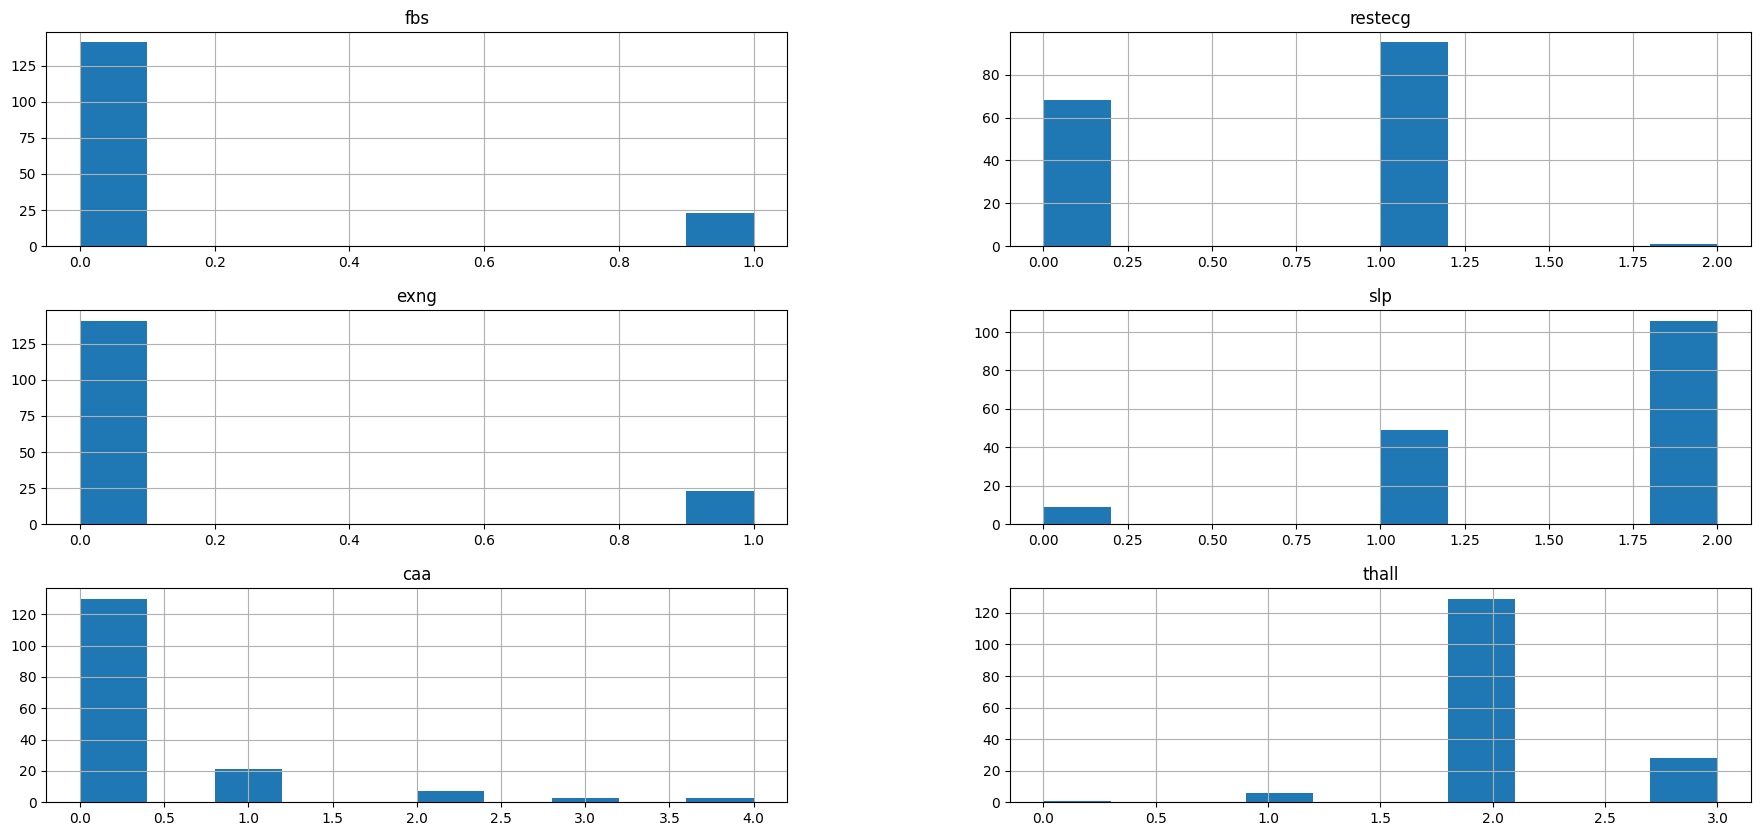

In [663]:
df[column_t][mask].hist(figsize=(22,10));

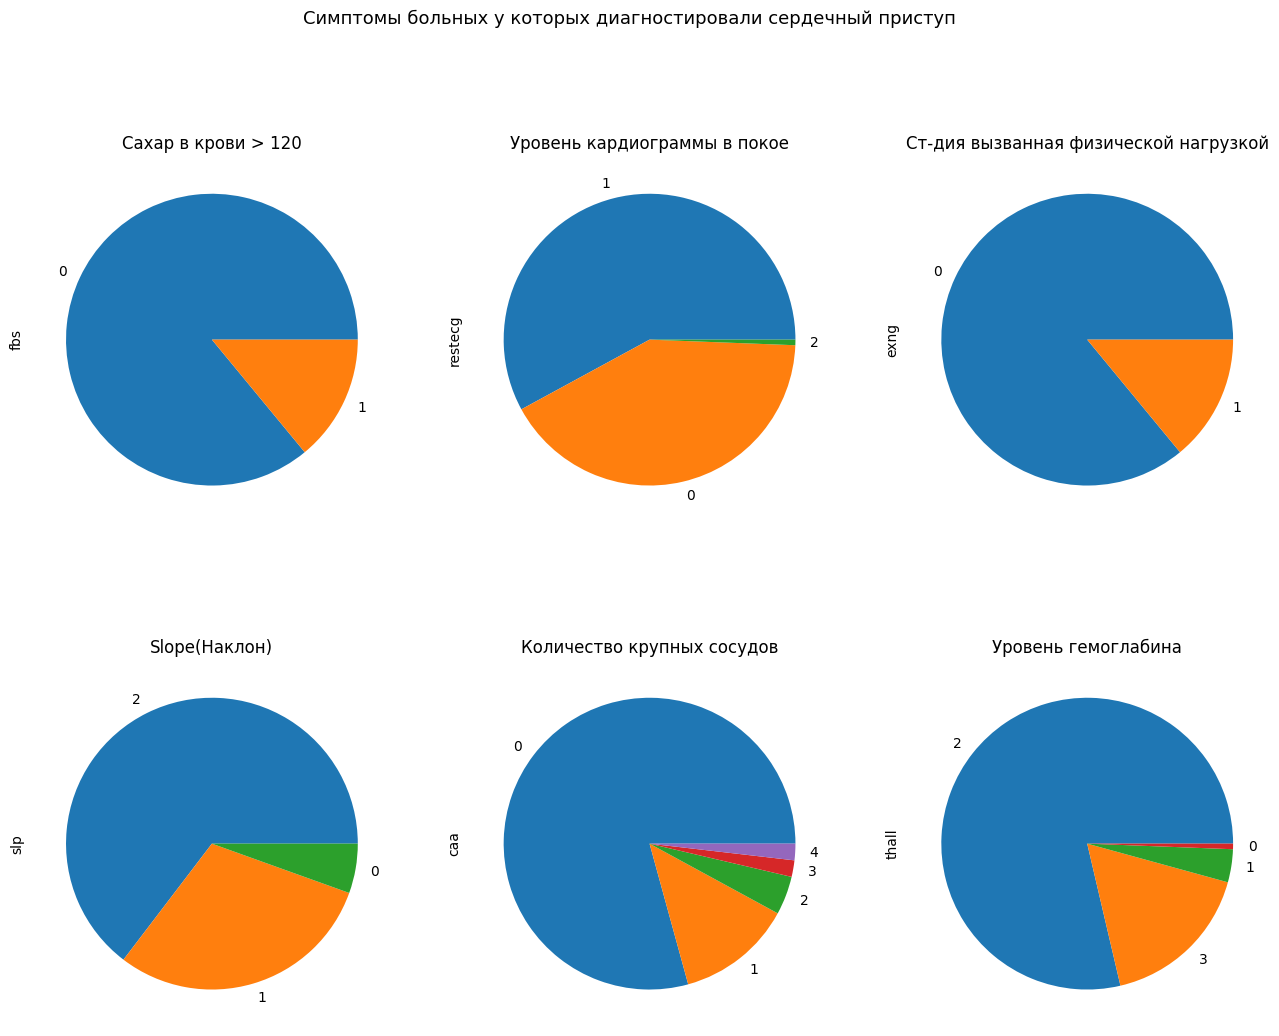

In [664]:
plt.figure(figsize=(16,12))
plt.suptitle("Симптомы больных у которых диагностировали сердечный приступ", fontsize=13)

for i in range(len(column_t)):
    plt.subplot(2, 3, i+1)
    dat = df[column_t[i]][mask]
    plt.title(title_t[i])
    dat.value_counts().plot.pie()

Баланс Классов


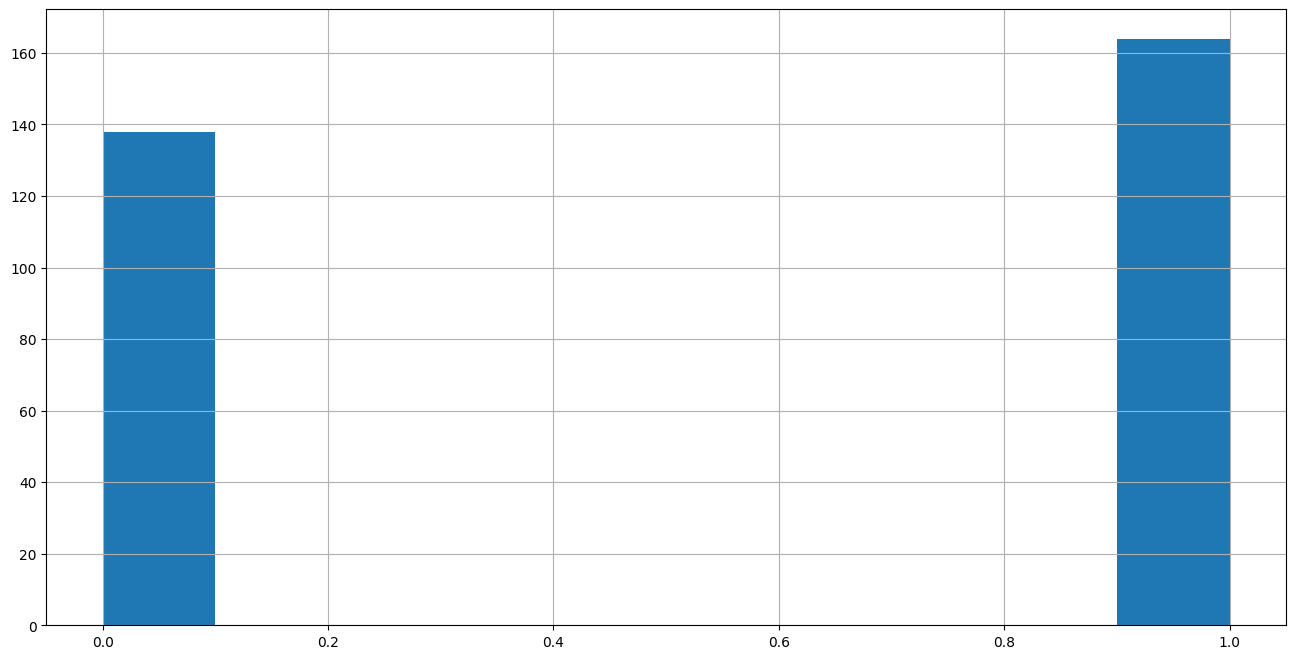

In [665]:
print('Баланс Классов')
df['output'].T.hist(figsize=(16,8));


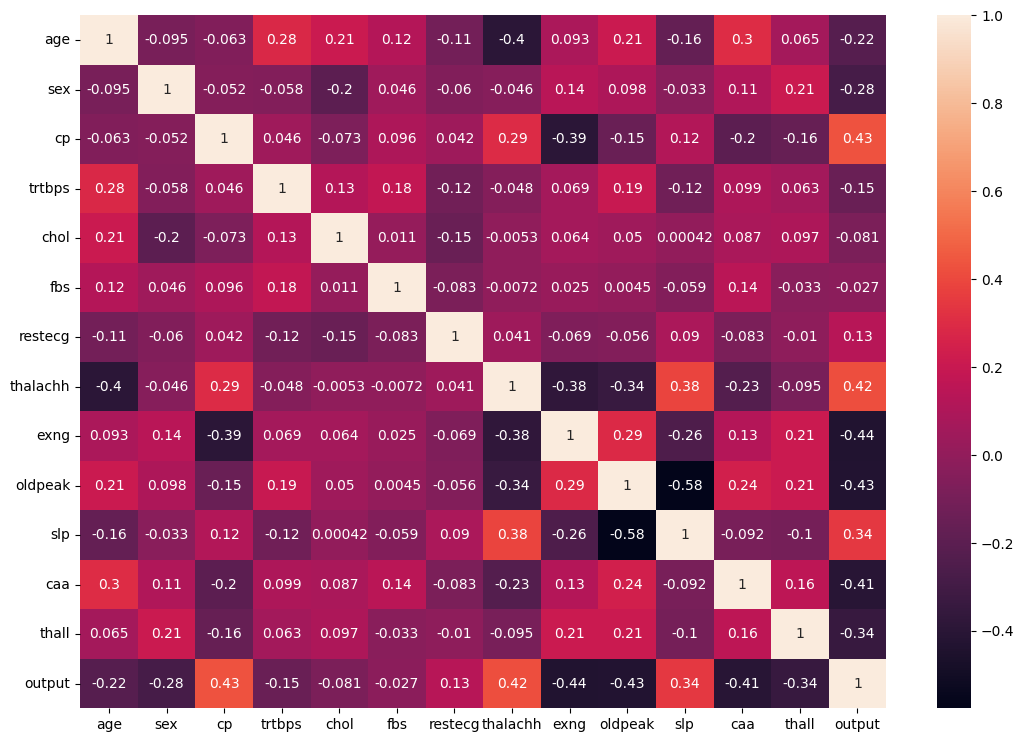

In [666]:
corr = df.corr()
plt.figure(figsize=(13, 9))
sns.heatmap(corr, annot=True);
# Строим тепловую карту корреляции

Из визуального анализа делаем вывод: 
- болше риск сердечного заболевания от 40-60 лет
- больше риск у людей с типом боли 2 типа
- больше риск у людей с 0 количеством больших сосудов
- больше риск у людей с стенокардией,вызванной физической нагрузкой
- больше риск у людей с высоким значением "OldPeak"
- данные имеют приемлимый баланс классов
   
Так же имеется положительная кореляция у:  
- Slp 
- Thalachh
- cp  

отрицательная корреляция:
- OldPeak
- exng

### 4. Предобработка (стратификация, скалеры)

In [667]:
df_knn = df.copy()
X = np.array(df_knn.drop(['output'],axis=1))
y = np.array(df_knn['output'])

In [ ]:
#  создаем сразу отнормированные данные для моделей
RS = RobustScaler().fit(X)
X_rs = RS.transform(X)

X_sc = scale(np.array(X, dtype='float'), with_std=True, with_mean=True)

MMS = MinMaxScaler().fit(X)
X_mm = MMS.transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_rs, y, test_size=0.2, stratify=y)
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y, test_size=0.2, stratify=y)
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_mm, y, test_size=0.2, stratify=y)


### 5. Построение алгоритмa KNN и перебор гиперпараметров -> Оценка -> Выбор


#### KNN

In [670]:
knn = KNeighborsClassifier()      # создали 4 модели для сравнения  
knn_rs = KNeighborsClassifier()     # c нормированием Robustscaler
knn_sc = KNeighborsClassifier()     # с нормированием Z
knn_mm = KNeighborsClassifier()     # с нормирование MinMax

# обучаем модели соответствующими данными
knn.fit(X_train,y_train)
knn_rs.fit(X_train_rs,y_train_rs)
knn_sc.fit(X_train_sc,y_train_sc)
knn_mm.fit(X_train_mm,y_train_mm)

# получаем прогноз по каждой из модели
preds = knn.predict(X_test)  
preds_rs = knn_rs.predict(X_test_rs)  
preds_sc = knn_sc.predict(X_test_sc)  
preds_mm = knn_mm.predict(X_test_mm)  

results_acscore_KNN  = {}
results_acscore_KNN['KNN'] = metrics.accuracy_score(y_test, preds)
results_acscore_KNN['KNN_robustscaler'] = metrics.accuracy_score(y_test_rs, preds_rs)
results_acscore_KNN['KNN_scaler_Z'] = metrics.accuracy_score(y_test_sc, preds_sc)
results_acscore_KNN['KNN_MinMax'] = metrics.accuracy_score(y_test_mm, preds_mm)




In [671]:
results_acscore_KNN

{'KNN': 0.6229508196721312,
 'KNN_robustscaler': 0.8360655737704918,
 'KNN_scaler_Z': 0.819672131147541,
 'KNN_MinMax': 0.8524590163934426}

In [672]:
clr(y_test, preds, "Без нормирования")
clr(y_test_rs, preds_rs, "RobustScaler")
clr(y_test_mm, preds_mm, "MinMaxScaler")
clr(y_test_sc, preds_sc, "Z-norm")

****************************************
Без нормирования
              precision    recall  f1-score   support

           0       0.61      0.50      0.55        28
           1       0.63      0.73      0.68        33

    accuracy                           0.62        61
   macro avg       0.62      0.61      0.61        61
weighted avg       0.62      0.62      0.62        61

****************************************
****************************************
RobustScaler
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.79      0.94      0.86        33

    accuracy                           0.84        61
   macro avg       0.85      0.83      0.83        61
weighted avg       0.85      0.84      0.83        61

****************************************
****************************************
MinMaxScaler
              precision    recall  f1-score   support

           0       0.85      0.82      0.84

#### Перебор гиперпараметров в GridSearch

In [673]:
    # модельки для GS
knn = KNeighborsClassifier()     
knn_rs = KNeighborsClassifier()     
knn_sc = KNeighborsClassifier()     
knn_mm = KNeighborsClassifier()  

knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 50), dtype='int')} 
    # Задаем параметры
gs = GridSearchCV(knn, knn_grid, cv=6, n_jobs=-1)
gs_rs = GridSearchCV(knn_rs, knn_grid, cv=6, n_jobs=-1)
gs_sc = GridSearchCV(knn_sc, knn_grid, cv=6, n_jobs=-1)
gs_mm = GridSearchCV(knn_mm, knn_grid, cv=6, n_jobs=-1)
    # Обучаем
gs.fit(X,y)
gs_rs.fit(X_rs,y)
gs_sc.fit(X_sc,y)
gs_mm.fit(X_mm,y)

GridSearchCV(cv=6, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97, 100])})

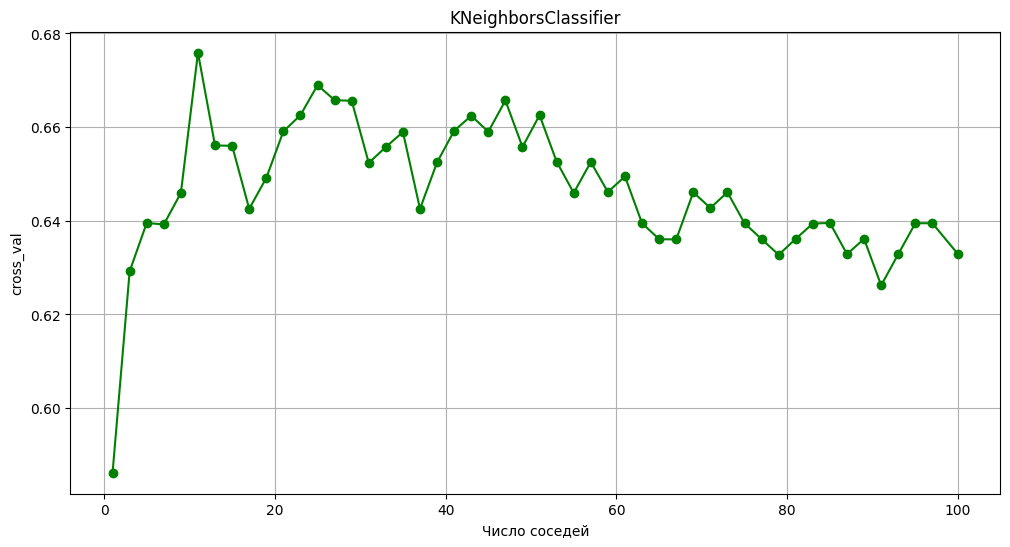

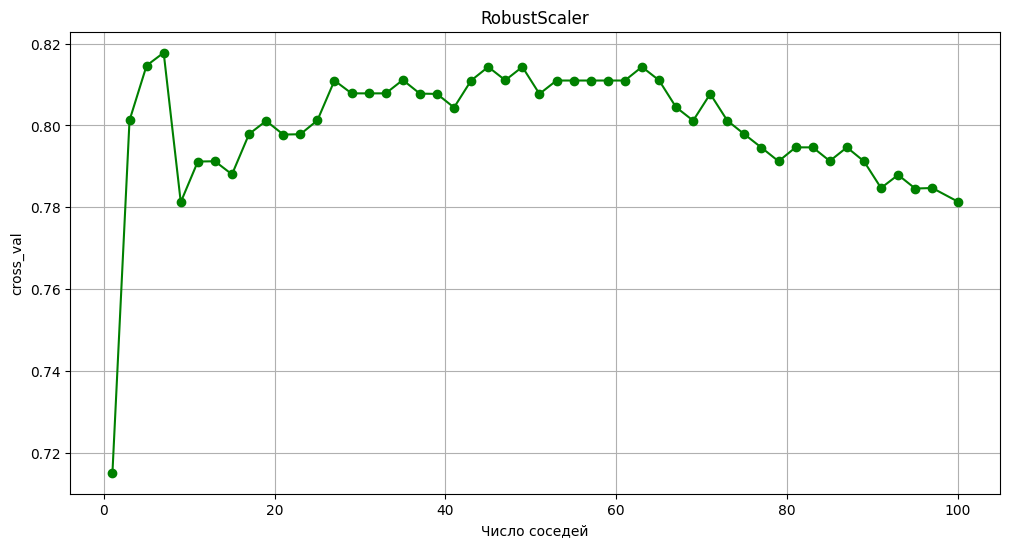

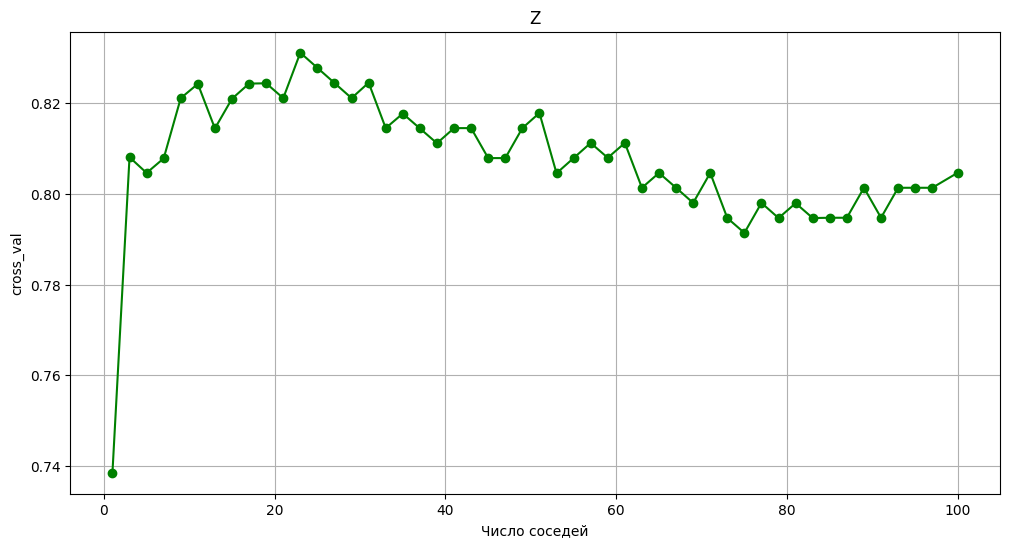

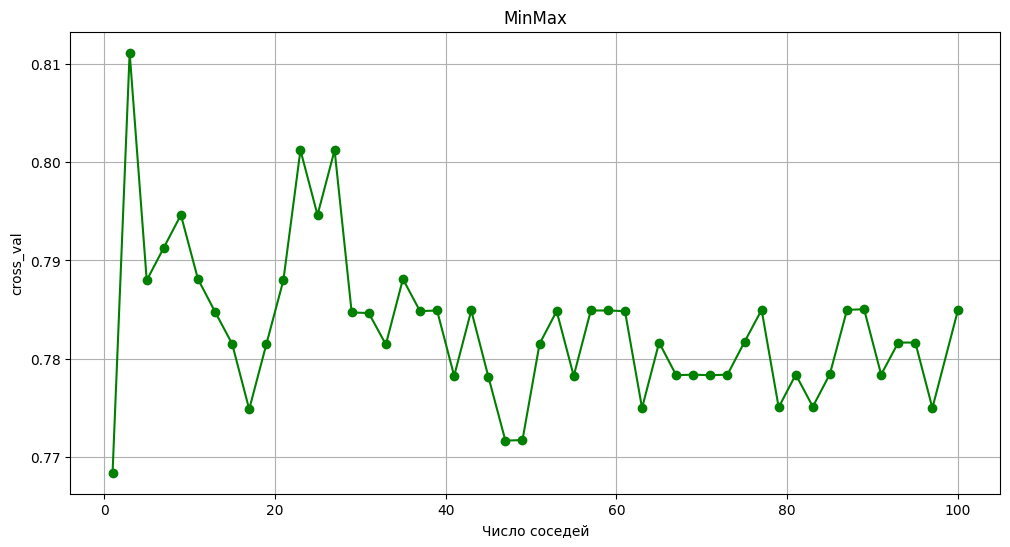

In [674]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'Число соседей', 'KNeighborsClassifier')
grid_plot(knn_grid['n_neighbors'], gs_rs.cv_results_['mean_test_score'], 'Число соседей', 'RobustScaler')
grid_plot(knn_grid['n_neighbors'], gs_sc.cv_results_['mean_test_score'], 'Число соседей', 'Z')
grid_plot(knn_grid['n_neighbors'], gs_mm.cv_results_['mean_test_score'], 'Число соседей', 'MinMax')

In [675]:
# напечатаем лучшие параметры и сохраним в переменные. 
print(gs.best_params_, gs.best_score_)
bp = gs.best_params_['n_neighbors']
print(gs_rs.best_params_, gs_rs.best_score_)
bp_rs = gs_rs.best_params_['n_neighbors']
print(gs_sc.best_params_, gs_sc.best_score_)
bp_sc = gs_sc.best_params_['n_neighbors']
print(gs_mm.best_params_, gs_mm.best_score_)
bp_mm = gs_mm.best_params_['n_neighbors']

{'n_neighbors': 11} 0.6758823529411764
{'n_neighbors': 7} 0.8177777777777777
{'n_neighbors': 23} 0.831045751633987
{'n_neighbors': 3} 0.8111764705882353


In [676]:
    # Построим все модельки с лучшими параметрами
knn = KNeighborsClassifier(n_neighbors = gs.best_params_['n_neighbors'])       
knn_rs = KNeighborsClassifier(n_neighbors = gs_rs.best_params_['n_neighbors'])     
knn_sc = KNeighborsClassifier(n_neighbors = gs_sc.best_params_['n_neighbors'])     
knn_mm = KNeighborsClassifier(n_neighbors = gs_mm.best_params_['n_neighbors'])     

# обучаем модели соответствующими данными
knn.fit(X_train, y_train)
knn_rs.fit(X_train_rs, y_train_rs)
knn_sc.fit(X_train_sc, y_train_sc)
knn_mm.fit(X_train_mm, y_train_mm)

# получаем прогноз по каждой из модели
preds = knn.predict(X_test)  
preds_rs = knn_rs.predict(X_test_rs)  
preds_sc = knn_sc.predict(X_test_sc)  
preds_mm = knn_mm.predict(X_test_mm)  


# далее получаем долю угаданных с нормированием и без
results_acscore_KNN_bp  = {}
results_acscore_KNN_bp['KNN'] = metrics.accuracy_score(y_test, preds)
results_acscore_KNN_bp['KNN_robustscaler'] = metrics.accuracy_score(y_test_rs, preds_rs)
results_acscore_KNN_bp['KNN_scaler_Z'] = metrics.accuracy_score(y_test_sc, preds_sc)
results_acscore_KNN_bp['KNN_MinMax'] = metrics.accuracy_score(y_test_mm, preds_mm)




#### Оценка

In [677]:
results_acscore_KNN_bp # accuracy с лучшими параметрами

{'KNN': 0.5901639344262295,
 'KNN_robustscaler': 0.8360655737704918,
 'KNN_scaler_Z': 0.7868852459016393,
 'KNN_MinMax': 0.8524590163934426}

In [678]:
results_acscore_KNN # accuracy без подбора параметров

{'KNN': 0.6229508196721312,
 'KNN_robustscaler': 0.8360655737704918,
 'KNN_scaler_Z': 0.819672131147541,
 'KNN_MinMax': 0.8524590163934426}

In [679]:
clr(y_test, preds, "Без нормирования")
clr(y_test_rs, preds_rs, "RobustScaler")
clr(y_test_sc, preds_sc, "Z-norm")
clr(y_test_mm, preds_mm, "MinMaxScaler")


****************************************
Без нормирования
              precision    recall  f1-score   support

           0       0.57      0.46      0.51        28
           1       0.61      0.70      0.65        33

    accuracy                           0.59        61
   macro avg       0.59      0.58      0.58        61
weighted avg       0.59      0.59      0.58        61

****************************************
****************************************
RobustScaler
              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.79      0.94      0.86        33

    accuracy                           0.84        61
   macro avg       0.85      0.83      0.83        61
weighted avg       0.85      0.84      0.83        61

****************************************
****************************************
Z-norm
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      

In [680]:
print('mean_absolute_error')
print(f'NoScaler - {metrics.mean_absolute_error(y_test, preds)}')
print(f'RobustCcaler - {metrics.mean_absolute_error(y_test_rs, preds_rs)}')
print(f'Z-NormScaler - {metrics.mean_absolute_error(y_test_sc, preds_sc)}')
print(f'MinMax Scaler - {metrics.mean_absolute_error(y_test_mm, preds_mm)}')



mean_absolute_error
NoScaler - 0.4098360655737705
RobustCcaler - 0.16393442622950818
Z-NormScaler - 0.21311475409836064
MinMax Scaler - 0.14754098360655737


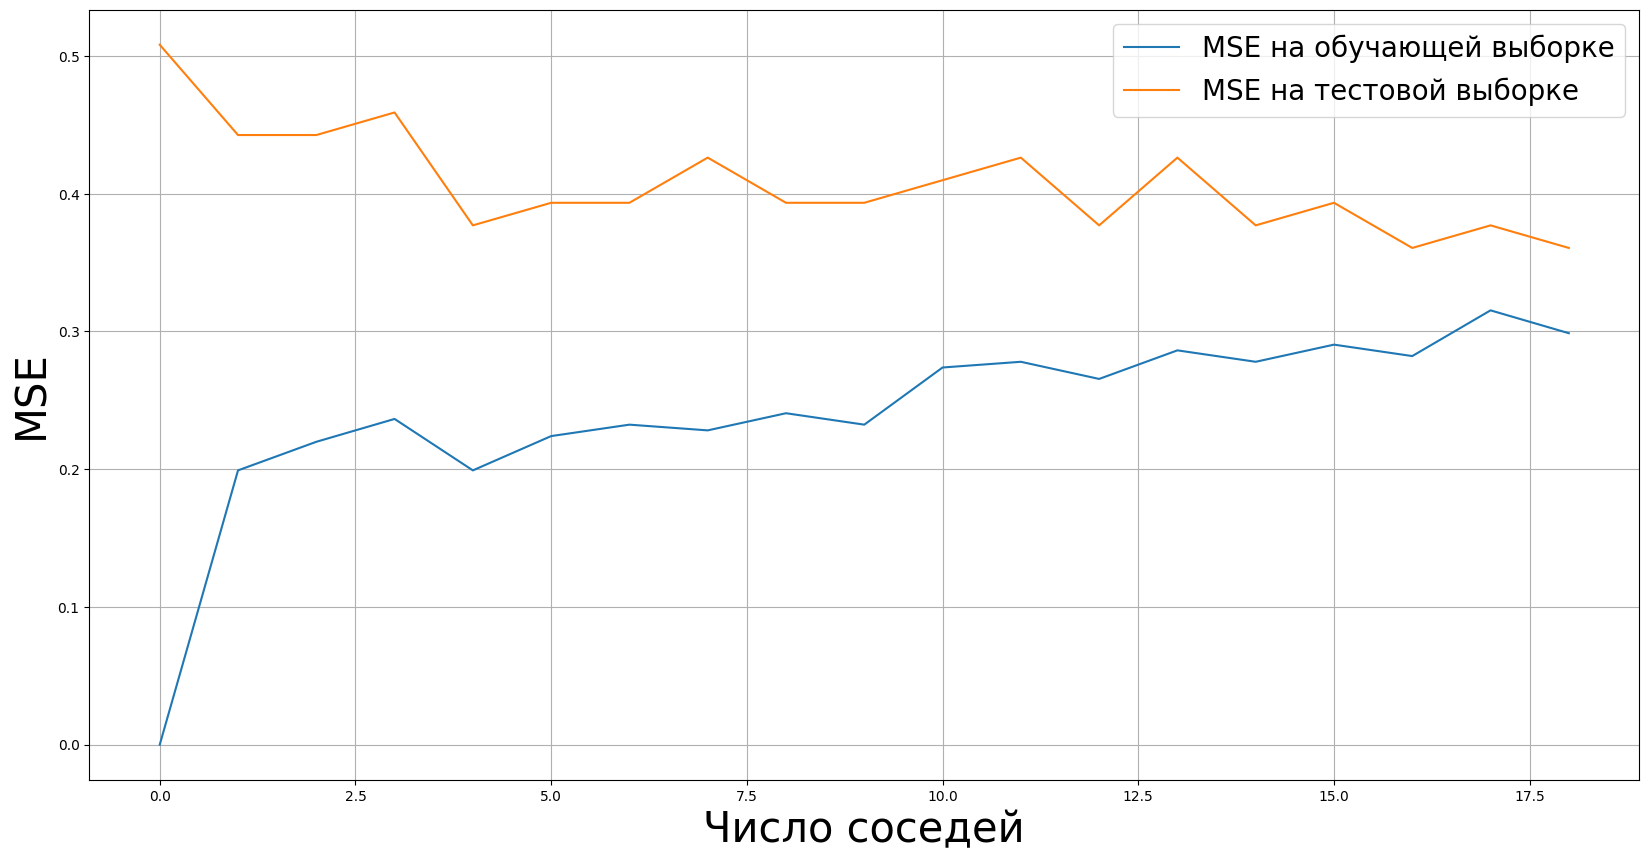

In [681]:
grid_knn( X_train, y_train, X_test, y_test, k=20)

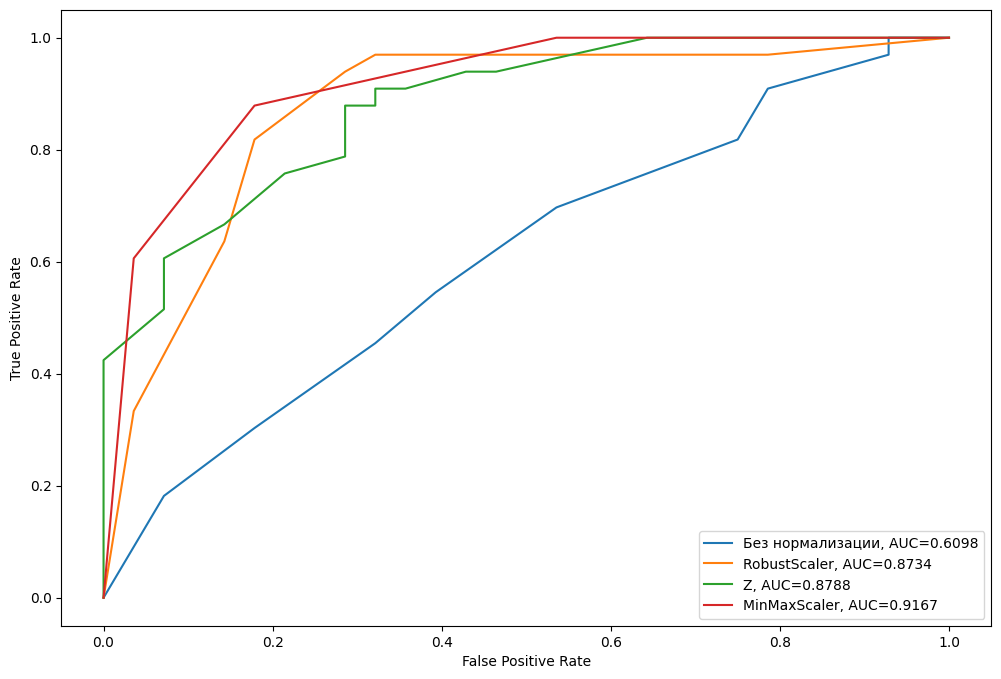

In [682]:
plt.figure(figsize=(12,8))


y_pred = knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Без нормализации, AUC="+str(auc))


y_pred_rs = knn_rs.predict_proba(X_test_rs)[:, 1]
fpr_rs, tpr_rs, _ = metrics.roc_curve(y_test_rs, y_pred_rs)
auc_rs = round(metrics.roc_auc_score(y_test_rs, y_pred_rs), 4)
plt.plot(fpr_rs,tpr_rs,label="RobustScaler, AUC="+str(auc_rs))

y_pred_sc = knn_sc.predict_proba(X_test_sc)[:, 1]
fpr_sc, tpr_sc, _ = metrics.roc_curve(y_test_sc, y_pred_sc)
auc_sc = round(metrics.roc_auc_score(y_test_sc, y_pred_sc), 4)
plt.plot(fpr_sc,tpr_sc,label="Z, AUC="+str(auc_sc))

y_pred_mm = knn_mm.predict_proba(X_test_mm)[:, 1]
fpr_mm, tpr_mm, _ = metrics.roc_curve(y_test_mm, y_pred_mm)
auc_mm = round(metrics.roc_auc_score(y_test_mm, y_pred_mm), 4)
plt.plot(fpr_mm,tpr_mm,label="MinMaxScaler, AUC="+str(auc_mm))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend();

#### Выбор  
По все метрикам лучшей моделькой оказалась KNN с MinMax нормированием.  
Далее будем собирать данные для таблицы сравнения других моделей с выбранной KNN.
Будем ориентироваться на accuracy и f1, recall по 1, так как 1 означает заболевание которое нам нужно выявить. а так же добавим среднеквадратичню ошибку.

In [683]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, mean_squared_error
for_df = []
for_df.append([     'KNN_MinMaxScaler',
    accuracy_score(y_test_mm, knn_mm.predict(X_test_mm)),
    f1_score(y_test_mm, knn_mm.predict(X_test_mm)),
    recall_score(y_test_mm, knn_mm.predict(X_test_mm)), 
    mean_squared_error(y_test_mm, knn_mm.predict(X_test_mm))
])

### Построение других алгоритмов

In [684]:
lr = LogisticRegression()

for_df.append([     'LogisticRegression',
    accuracy_score(y_test_mm, lr.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    f1_score(y_test_mm, lr.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    recall_score(y_test_mm, lr.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    mean_squared_error(y_test_mm, lr.fit(X_train_mm,y_train_mm).predict(X_test_mm))
    ])

In [685]:
rfc = RandomForestClassifier(criterion='entropy')
rfc_grid = {'n_estimators': np.array(np.linspace(1, 20, 10), dtype='int')
} 
gs_rfc = GridSearchCV(rfc, rfc_grid, cv=5, n_jobs=-1)
gs_rfc.fit(X_train_mm, y_train_mm)
   
rf = RandomForestClassifier(n_estimators=gs_rfc.best_params_["n_estimators"],criterion='entropy')
for_df.append([     'RandomForestClassifier',
    accuracy_score(y_test_mm, rf.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    f1_score(y_test_mm, rf.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    recall_score(y_test_mm, rf.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    mean_squared_error(y_test_mm, rf.fit(X_train_mm,y_train_mm).predict(X_test_mm))
    ])

In [686]:
dtc = DecisionTreeClassifier(criterion = 'gini',
                             splitter = 'random', 
                             random_state = 42)
for_df.append([         'DecisionTreeClassifier',
    accuracy_score(y_test_mm, dtc.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    f1_score(y_test_mm, dtc.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    recall_score(y_test_mm, dtc.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    mean_squared_error(y_test_mm, dtc.fit(X_train_mm,y_train_mm).predict(X_test_mm))
    ])

In [687]:
gb =GradientBoostingClassifier(criterion = 'squared_error')
grid_gb = {'n_estimators': np.linspace(1,30,10, dtype = int)
}
gs_gb = GridSearchCV(gb, grid_gb, cv = 5, n_jobs = -1)
gs_gb.fit(X_train_mm, y_train_mm)

gb =GradientBoostingClassifier(n_estimators=gs_gb.best_params_['n_estimators'], criterion = 'squared_error')
for_df.append([         'GradientBoostingClassifier',
    accuracy_score(y_test_mm, gb.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    f1_score(y_test_mm, gb.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    recall_score(y_test_mm, gb.fit(X_train_mm,y_train_mm).predict(X_test_mm)),
    mean_squared_error(y_test_mm, gb.fit(X_train_mm,y_train_mm).predict(X_test_mm))
    ])

In [688]:
df = pd.DataFrame(for_df, columns = ['alg', 'accuracy', 'f1', 'recall', 'MSE'])

In [689]:
df

,alg,accuracy,f1,recall,MSE
0,KNN_MinMaxScaler,0.852459,0.865672,0.878788,0.147541
1,LogisticRegression,0.836066,0.857143,0.909091,0.163934
2,RandomForestClassifier,0.819672,0.848485,0.848485,0.213115
3,DecisionTreeClassifier,0.819672,0.835821,0.848485,0.180328
4,GradientBoostingClassifier,0.786885,0.805970,0.818182,0.213115


### Оценка алгоритмов

При построении данных алгоритмов метрики меняются в зависимости от разбивки данных. Это связанно с с их небольшим количесвтом для оценки.
Для оценки среднего по всем метрикам выполним алгоритм разбивки 1000 раз и на каждом будем считать все метрики для усреднения в конце.

In [696]:
knn_acc = []
knn_f1 = []
knn_recall = []
knn_mse = []

lr_acc = []
lr_f1 = []
lr_recall = []
lr_mse = []

rf_acc = []
rf_f1 = []
rf_recall = []
rf_mse = []

dt_acc = []
dt_f1 = []
dt_recall = []
dt_mse = []

gb_acc = []
gb_f1 = []
gb_recall = []
gb_mse = []


In [719]:
for _ in range(1000):
    X_mm = MinMaxScaler().fit_transform(X)
    # Модель KNN
    X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_mm, y, test_size=0.2, stratify=y)
    knn_mm = KNeighborsClassifier()  
    knn_grid = {'n_neighbors': np.array(np.linspace(1, 100, 50), dtype='int')} 
    gs_mm = GridSearchCV(knn_mm, knn_grid, cv=5, n_jobs=-1)
    gs_mm.fit(X_mm,y) 
    knn_mm = KNeighborsClassifier(n_neighbors = gs_mm.best_params_['n_neighbors'])     
    knn_mm.fit(X_train_mm, y_train_mm)
    knn_acc.append(accuracy_score(y_test_mm, knn_mm.predict(X_test_mm)))
    knn_f1.append(f1_score(y_test_mm, knn_mm.predict(X_test_mm)))
    knn_recall.append(recall_score(y_test_mm, knn_mm.predict(X_test_mm)))
    knn_mse.append(mean_squared_error(y_test_mm, knn_mm.predict(X_test_mm)))
    # Модель LR

    lr = LogisticRegression()

    lr_acc.append(accuracy_score(y_test_mm, lr.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    lr_f1.append(f1_score(y_test_mm, lr.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    lr_recall.append(recall_score(y_test_mm, lr.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    lr_mse.append(mean_squared_error(y_test_mm, lr.fit(X_train_mm,y_train_mm).predict(X_test_mm)))

    dtc = DecisionTreeClassifier(criterion = 'gini',
                                splitter = 'random', 
                                random_state = 42)

    dt_acc.append(accuracy_score(y_test_mm, dtc.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    dt_f1.append(f1_score(y_test_mm, dtc.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    dt_recall.append(recall_score(y_test_mm, dtc.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    dt_mse.append(mean_squared_error(y_test_mm, dtc.fit(X_train_mm,y_train_mm).predict(X_test_mm)))

    gb =GradientBoostingClassifier(criterion = 'squared_error')
    grid_gb = {'n_estimators': np.linspace(1,30,10, dtype = int)
    }
    gs_gb = GridSearchCV(gb, grid_gb, cv = 5, n_jobs = -1)
    gs_gb.fit(X_train_mm, y_train_mm)
    gb =GradientBoostingClassifier(n_estimators=gs_gb.best_params_['n_estimators'], criterion = 'squared_error')
    gb_acc.append(accuracy_score(y_test_mm, gb.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    gb_f1.append(f1_score(y_test_mm, gb.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    gb_recall.append(recall_score(y_test_mm, gb.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    gb_mse.append(mean_squared_error(y_test_mm, gb.fit(X_train_mm,y_train_mm).predict(X_test_mm)))

    rfc = RandomForestClassifier(criterion='entropy')
    rfc_grid = {'n_estimators': np.array(np.linspace(1, 20, 10), dtype='int')
    } 
    gs_rfc = GridSearchCV(rfc, rfc_grid, cv=5, n_jobs=-1)
    gs_rfc.fit(X_train_mm, y_train_mm)
    
    rf = RandomForestClassifier(n_estimators=gs_rfc.best_params_["n_estimators"],criterion='entropy')
    rf_acc.append(accuracy_score(y_test_mm, rf.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    rf_f1.append(f1_score(y_test_mm, rf.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    rf_recall.append(recall_score(y_test_mm, rf.fit(X_train_mm,y_train_mm).predict(X_test_mm)))
    rf_mse.append(mean_squared_error(y_test_mm, rf.fit(X_train_mm,y_train_mm).predict(X_test_mm)))

    

In [736]:
for_df_algs = []

In [737]:
for_df_algs.append([         'KNN',
                    np.mean(knn_acc),
                    np.mean(knn_f1),
                    np.mean(knn_recall),
                    np.mean(knn_mse),
                    ])
for_df_algs.append([         'LR',
                    np.mean(lr_acc),
                    np.mean(lr_f1),
                    np.mean(lr_recall),
                    np.mean(lr_mse),
                    ])
for_df_algs.append([         'DT',
                    np.mean(dt_acc),
                    np.mean(dt_f1),
                    np.mean(dt_recall),
                    np.mean(dt_mse),
                    ])
for_df_algs.append([         'RF',
                    np.mean(rf_acc),
                    np.mean(rf_f1),
                    np.mean(rf_recall),
                    np.mean(rf_mse),
                    ])
for_df_algs.append([         'GB',
                    np.mean(gb_acc),
                    np.mean(gb_f1),
                    np.mean(gb_recall),
                    np.mean(gb_mse),
                    ])

In [738]:
df = pd.DataFrame(for_df_algs, columns = ['alg', 'accuracy', 'f1', 'recall', 'MSE'])

In [739]:
df

,alg,accuracy,f1,recall,MSE
0,KNN,0.803989,0.820955,0.832652,0.196011
1,LR,0.822678,0.844402,0.889015,0.177322
2,DT,0.762623,0.781174,0.786919,0.237377
3,RF,0.805231,0.822869,0.843719,0.194262
4,GB,0.802964,0.826743,0.870202,0.197049


0.8039890710382513

### Вывод:  
В итоге лучшая метрики для этой задачи с предложенной обработкой даннных показывает нам Логистическая регрессия, почти в 90 случаях из 100 мы можем предсказать болезнь сердца по имеющимся данным. 